# Speaker Embeddings Extraction Tutorial

## Introduction

This tutorial demonstrates how to use the `extract_speaker_embeddings_from_audios` function to extract speaker embeddings from audio files. Speaker embeddings are fixed-dimensional vector representations that capture the unique characteristics of a speaker's voice, which can be used for various tasks such as speaker identification, verification, and diarization.

## Setup
First, let's import the necessary libraries and the function we'll be using.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from senselab.audio.data_structures.audio import Audio
from senselab.utils.data_structures.model import SpeechBrainModel
from senselab.utils.data_structures.device import DeviceType
from senselab.audio.tasks.speaker_embeddings.api import extract_speaker_embeddings_from_audios
from senselab.audio.tasks.preprocessing.preprocessing import downmix_audios_to_mono
from senselab.audio.tasks.preprocessing.preprocessing import resample_audios

/om2/user/mbsilva/anaconda/envs/senselab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/om2/user/mbsilva/anaconda/envs/senselab/lib/python3.12/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_info" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## Loading Audio Files
Now let's load and process the audio files using senselab's built-in tools to do so.

In [2]:
audio1 = Audio.from_filepath("../src/tests/data_for_testing/audio_48khz_mono_16bits.wav")
audio2 = Audio.from_filepath("../src/tests/data_for_testing/audio_48khz_stereo_16bits.wav")

# Downmix to mono
audio2 = downmix_audios_to_mono([audio2])[0]

# Resample both audios to 16kHz
audios = resample_audios([audio1, audio2], 16000)

## Extracting Speaker Embeddings

Now, let's use the `extract_speaker_embeddings_from_audios` function to extract embeddings from our audio files. We will use the ecapa-tdnn model here, but feel free to use any speechbrain compatible model.

In [3]:
model = SpeechBrainModel(path_or_uri="speechbrain/spkrec-ecapa-voxceleb", revision="main")
device = DeviceType.CUDA if torch.cuda.is_available() else DeviceType.CPU
embeddings = extract_speaker_embeddings_from_audios(audios, model, device)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Embedding size for file 1: {embeddings[0].shape}")
print(f"Embedding size for file 2: {embeddings[1].shape}")

Number of embeddings: 2
Embedding size for file 1: torch.Size([192])
Embedding size for file 2: torch.Size([192])


## Visualizing Embeddings
That's pretty much it! Now we can use the extracted speaker embeddings for any downstream tasks we require.

For example, we can visualize the embeddings like this:

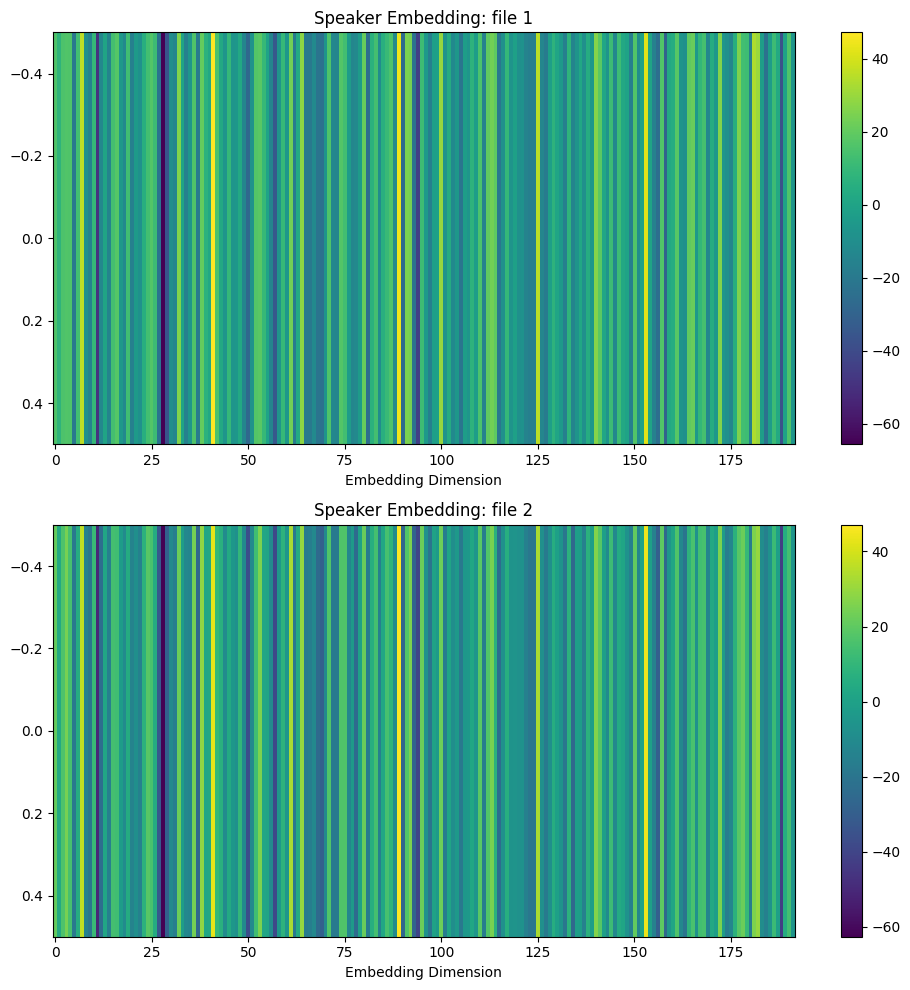

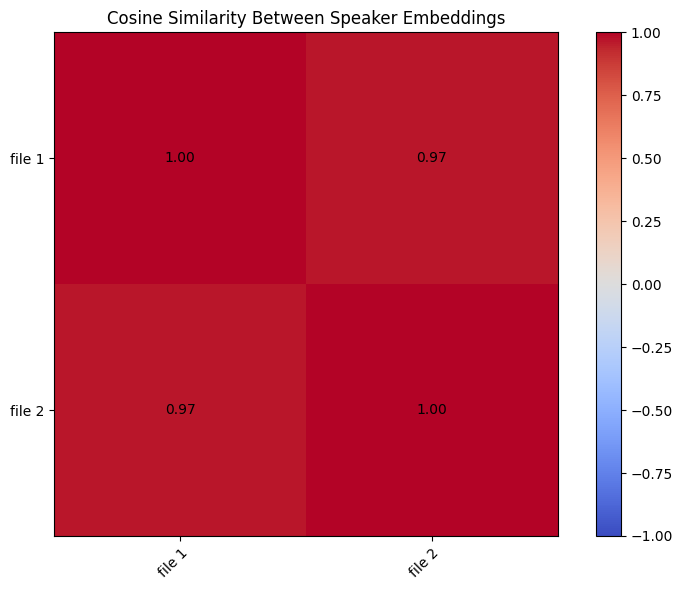

In [4]:
def plot_embedding_heatmap(embeddings: List[torch.Tensor], titles: List[str]):
    fig, axes = plt.subplots(len(embeddings), 1, figsize=(10, 5 * len(embeddings)))
    if len(embeddings) == 1:
        axes = [axes]
    
    for ax, embedding, title in zip(axes, embeddings, titles):
        im = ax.imshow(embedding.unsqueeze(0), aspect='auto', cmap='viridis')
        ax.set_title(f"Speaker Embedding: {title}")
        ax.set_xlabel("Embedding Dimension")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

plot_embedding_heatmap(embeddings, ["file 1", "file 2"])

def cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> float:
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

def plot_similarity_matrix(embeddings: List[torch.Tensor], labels: List[str]):
    n = len(embeddings)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(similarity_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{similarity_matrix[i, j]:.2f}", ha="center", va="center", color="black")
    
    ax.set_title("Cosine Similarity Between Speaker Embeddings")
    fig.colorbar(im)
    plt.tight_layout()
    plt.show()

plot_similarity_matrix(embeddings, ["file 1", "file 2"])

## Conclusion

This tutorial demonstrated how to use the `extract_speaker_embeddings_from_audios` function to extract speaker embeddings from audio files. We visualized the embeddings and compared them using cosine similarity. These embeddings can be used for various speaker recognition tasks, such as speaker identification, verification, and diarization.

Remember that the performance of these embeddings can vary depending on the specific dataset, task, and evaluation protocol used. Always refer to the most recent literature for up-to-date benchmarks and best practices in speaker recognition tasks.